# Investigating the DNN based electron ID

This study uses a flattened ntuple containing the DNN scores for individual electrons (along with other variables which I am ignoring for now). The input files from which these flat ntuples are produced are MiniAOD samples from the Run3Winter22 campaign (`CMSSW_12_2_3_patch1`).

The DNN-ID for the electrons is based on the following scores of a multiclassifier.
```
'dnn_signal_Isolated'
'dnn_signal_nonIsolated'
'dnn_bkg_nonIsolated'
'dnn_bkg_Tau'
'dnn_bkg_Photon'
```

The MVA scores used in this study are the following.
```
'Fall17IsoV2Vals'
'Fall17IsoV2RawVals'
'RunIIIWinter22IsoV1Vals'
'RunIIIWinter22IsoV1RawVals'
```

These variables in the ntuple are produced using the following script. This he ntuple maker runs in a `CMSSW_13_0_8` environment which has the new RunIII MVA scores. 

**ntuple maker:** <a href="https://github.com/cms-sw/cmssw/blob/master/RecoEgamma/ElectronIdentification/test/testElectronMVA_cfg.py">GitHub: cmssw/RecoEgamma/ElectronIdentification/test
/testElectronMVA_cfg.py</a> 

#### The goal of this study is to compare these scores with the MVA scores.

### Reading the input files as dataframes:

In [1]:
import os, sys
import uproot
filedy = uproot.open('inputs/Run3Winter22/electron_ntuple_DYJetsToLL_M-50.root')
filett = uproot.open('inputs/Run3Winter22/electron_ntuple_TTToSemiLeptonic.root')
filetau = uproot.open('inputs/Run3Winter22/electron_ntuple_TauGun_Pt-15to500.root')
print('The input files are read using uproot.')

The input files are read using uproot.


In [2]:
import pandas as pd
import numpy as np

treedy = filedy['ntuplizer/tree']
treett = filett['ntuplizer/tree']
treetau= filetau['ntuplizer/tree']

branches = [
    'matchedToGenEle', #flag for deciding whether it is a signal or background electron 
    'dnn_signal_Isolated', 'dnn_signal_nonIsolated', 'dnn_bkg_nonIsolated', 'dnn_bkg_Tau', 'dnn_bkg_Photon', #DNN scores
    'Fall17IsoV2Vals', 'Fall17IsoV2RawVals', #MVA IDs from Run2
    'RunIIIWinter22IsoV1Vals', 'RunIIIWinter22IsoV1RawVals' #MVA IDs from Run3
]

#Turning the branches into awkward arrays, then into dataframes:
def make_df(tree, branches, samplename):
    awkarray = tree.arrays(branches)
    df = pd.DataFrame(awkarray.to_list())
    df['sample'] = samplename
    return df
    
dfdy = make_df(treedy, branches, 'drellyan')
dftt = make_df(treett, branches, 'ttbar')
dftau = make_df(treetau, branches, 'taugun')

#The final dataframe containing everything:
#This is I you decide which samples I want to add
df=pd.concat([dfdy, dftt])

#renaming columns for my convenience:
rename = {
    'dnn_signal_Isolated':'score1',
    'dnn_signal_nonIsolated':'score2',
    'dnn_bkg_nonIsolated':'score3',
    'dnn_bkg_Tau':'score4',
    'dnn_bkg_Photon':'score5',
    'matchedToGenEle':'genmatch',
    'Fall17IsoV2Vals':'MVA1',
    'Fall17IsoV2RawVals':'MVA2',
    'RunIIIWinter22IsoV1Vals':'MVA3',
    'RunIIIWinter22IsoV1RawVals':'MVA4'
}

#Reversing this dictionary for later use
alias = {value: key for key, value in rename.items()}

df.rename(columns = rename, inplace = True)

#Let's normalize the variables from 0 to 1
def normalize_col(df, col):
    if df[col].max() != df[col].min():
        df[col] = (df[col]-df[col].min()) / (df[col].max()-df[col].min())
    else:
        print('Scaling error: max and min are the same!')
    return df

#Only the MVA scores require normalization
df=normalize_col(df, 'MVA1')
df=normalize_col(df, 'MVA2')
df=normalize_col(df, 'MVA3')
df=normalize_col(df, 'MVA4')

df

,genmatch,score1,score2,score3,score4,score5,MVA1,MVA2,MVA3,MVA4,sample
0,1,0.863116,0.004818,0.000275,0.004286,0.127505,9.997123e-01,0.682085,0.821210,0.999967,drellyan
1,1,0.989065,0.001232,0.000117,0.003947,0.005639,9.999998e-01,0.837609,0.924249,0.999999,drellyan
2,2,0.825752,0.009598,0.004022,0.119532,0.041096,9.999973e-01,0.779701,0.752002,0.999586,drellyan
3,1,0.842872,0.004903,0.003169,0.059217,0.089840,9.998893e-01,0.702120,0.745797,0.997397,drellyan
4,1,0.990293,0.000186,0.000033,0.003566,0.005922,1.000000e+00,0.927975,0.931650,0.999999,drellyan
...,...,...,...,...,...,...,...,...,...,...,...
11668,0,0.000908,0.044618,0.755505,0.196291,0.002678,5.999207e-05,0.307180,0.201750,0.000004,ttbar
11669,0,0.018403,0.172200,0.506122,0.281282,0.021994,6.641322e-02,0.455638,0.369489,0.016802,ttbar
11670,0,0.019545,0.030449,0.158515,0.737870,0.053620,3.278255e-07,0.197361,0.269389,0.000051,ttbar
11671,0,0.055907,0.066272,0.423152,0.261170,0.193500,1.963675e-04,0.332053,0.347673,0.000263,ttbar


### Defining signal and background electrons:

The variable, `matchedToGenEle` contains integers, which mean the following things:

- 0: The candidate does not match to any gen-electron. (fake)
- 1: The candidate is a prompt, real electron; matches to gen-electron.
- 2: The candidate is a prompt, gen-matched electron decaying from a tau (not part of a jet).
- 3: The candidate is a real electron, but not isolated.

The signal electrons have `matchedToGenEle == 1 OR 2`<br>
The backgrounds have `matchedToGenEle == 0 OR 3`

In [3]:
sig_flag = (df['genmatch'] == 1) | (df['genmatch'] == 2)
bkg_flag = (df['genmatch'] == 0) | (df['genmatch'] == 3)

df.loc[sig_flag, 'truth'] = 1
df.loc[bkg_flag, 'truth'] = 0

#Randomizing rows:
df = df.sample(frac=1) #randomizing rows
df.reset_index(inplace=True, drop=True)

def print_info(df, samplename):
    num = df[df["sample"] == samplename].shape[0]
    nsig =df[(df["sample"]==samplename)&(df["truth"]==1)].shape[0]
    nbkg =df[(df["sample"]==samplename)&(df["truth"]==0)].shape[0]
    if num!= 0:
        sig_frac = nsig*100/num
        bkg_frac = nbkg*100/num
    else:
        sig_frac = -1
        bkg_frac = -1
    print(f'Sample : {samplename}; \tnCandidates = {num}; '+
          f'nsig = {nsig} ({sig_frac:.1f}%), nbkg = {nbkg} ({bkg_frac:.1f}%)')
    
print_info(df, 'drellyan')
print_info(df, 'ttbar')
print_info(df, 'taugun')

Sample : drellyan; 	nCandidates = 6451; nsig = 5058 (78.4%), nbkg = 1393 (21.6%)
Sample : ttbar; 	nCandidates = 11673; nsig = 3339 (28.6%), nbkg = 8334 (71.4%)
Sample : taugun; 	nCandidates = 0; nsig = 0 (-1.0%), nbkg = 0 (-1.0%)


### DNN scores:

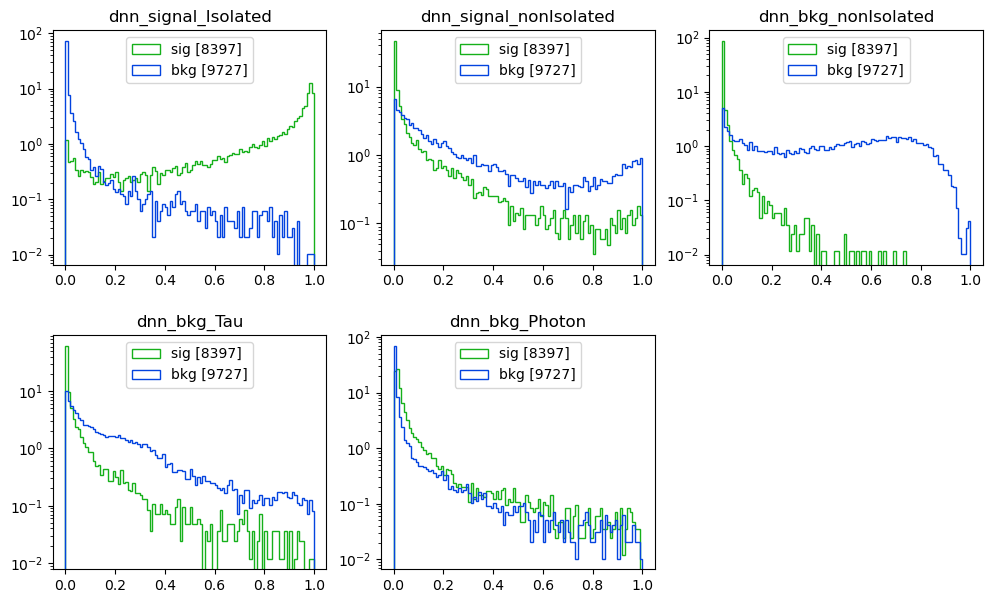

In [4]:
os.system('mkdir -p plots')

import matplotlib as mpl
import matplotlib.pyplot as plt

nsig=df[df['truth']==1].shape[0]
nbkg=df[df['truth']==0].shape[0]

fig1, ax1 = plt.subplots(2,3,figsize=(12,7))
ax1 = ax1.flatten()
fig1.subplots_adjust(hspace=0.3)

#fig1.subplots_adjust(hspace=0.5, wspace=0.1)
bins_=np.arange(0, 1.01, 0.01)
#fig1.delaxes(ax1[-1]) #Removing the last subplot
#fig1.suptitle('DNN scores') #Global title

vardnn = ['score1', 'score2', 'score3', 'score4', 'score5']

for i in range(len(vardnn)):
    ax1[i].hist(df[df['truth']==1][vardnn[i]], bins=bins_, histtype='step',
                color='xkcd:green',  label=f'sig [{nsig}]', density=True)
    ax1[i].hist(df[df['truth']==0][vardnn[i]], bins=bins_, histtype='step',
                color='xkcd:blue',  label=f'bkg [{nbkg}]', density=True)
    ax1[i].set_title(alias[vardnn[i]])
    ax1[i].set_yscale('log')
    ax1[i].legend(loc='upper center')
    
#ax1[-1].text(0, 1, text, transform=ax1[-1].transAxes, fontsize=10, ha='left', va='top')
ax1[-1].axis('off')

plt.show()

### MVA scores:

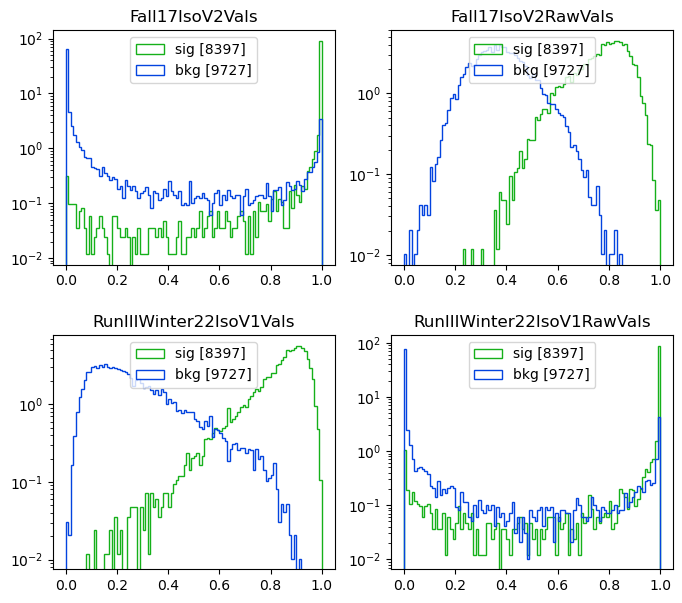

In [5]:
fig2, ax2 = plt.subplots(2,2,figsize=(8,7))
ax2 = ax2.flatten()
fig2.subplots_adjust(hspace=0.3)

bins_=np.arange(0, 1.01, 0.01)
#fig1.delaxes(ax1[-1]) #Removing the last subplot
#fig2.suptitle('MVA scores') #Global title

varmva = ['MVA1','MVA2','MVA3','MVA4']

for i in range(len(varmva)):
    ax2[i].hist(df[df['truth']==1][varmva[i]], bins=bins_, histtype='step',
                color='xkcd:green',  label=f'sig [{nsig}]', density=True)
    ax2[i].hist(df[df['truth']==0][varmva[i]], bins=bins_, histtype='step',
                color='xkcd:blue',  label=f'bkg [{nbkg}]', density=True)
    ax2[i].set_title(alias[varmva[i]])
    ax2[i].set_yscale('log')
    ax2[i].legend(loc='upper center')
    
#ax2[-1].text(0, 1, text, transform=ax2[-1].transAxes, fontsize=10, ha='left', va='top')
#ax2[-1].axis('off')

plt.show()

## ROC for the DNN scores and the MVA IDs

In [6]:
#ROC calculation:
from sklearn.metrics import roc_curve,auc

true = df['truth'] #Either 0, or 1

ROC_dict ={
    "score1":{},
    "score2":{},
    "score3":{},
    "score4":{},
    "score5":{},
    "MVA1":{},
    "MVA2":{},
    "MVA3":{},
    "MVA4":{},
}

def find_tpr_fnr_auc(true, pred):
    fpr, tpr, _ = roc_curve(true, pred)
    auc_score   = auc(tpr,1-fpr)
    tpr=tpr*100
    fnr=(1-fpr)*100
    return fnr, tpr, auc_score

for score, scoredict in ROC_dict.items():
    fnr, tpr, auc_score = find_tpr_fnr_auc(true, df[score])
    scoredict["fnr"] = fnr
    scoredict["tpr"] = tpr
    scoredict["auc"] = auc_score
    
#Sorting it according to AUC
import collections
ROC_dict = collections.OrderedDict(sorted(ROC_dict.items(), key=lambda x: x[1]["auc"], reverse=True))

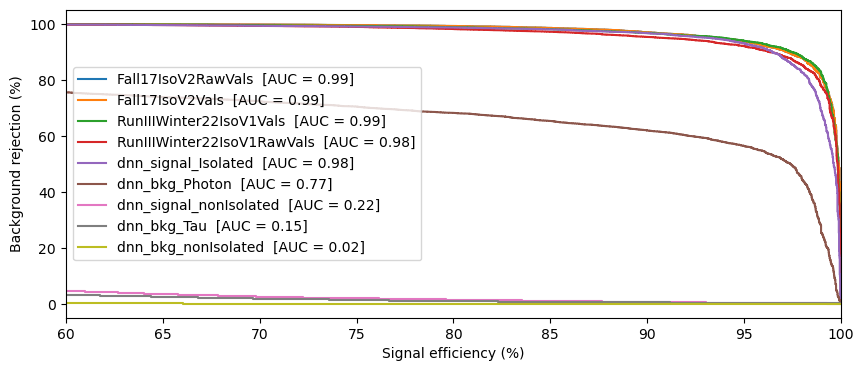

In [7]:
fig3, ax3 = plt.subplots(1,1,figsize=(10,4))

for score, scoredict in ROC_dict.items():
    tpr = scoredict["tpr"]
    fnr = scoredict["fnr"]
    auc = scoredict["auc"]
    label_ = alias[score]+f'  [AUC = {auc:.2f}]'
    ax3.plot(tpr,fnr, label=label_)

threshold = 0.80
nsig = df[df['truth']==1].shape[0]
nsigpass = df[(df['truth']==1) & (df['score1']+df['score2']>threshold)].shape[0]
sigeff = (nsigpass/nsig)*100
nbkg = df[df['truth']==0].shape[0]
nbkgfail = df[(df['truth']==0) & (df['score1']+df['score2']<threshold)].shape[0]
bkgrej = (nbkgfail/nbkg)*100
#plt.plot(sigeff, bkgrej, marker='o', color="red", markersize=6, label=f'Current DNN wp ~ {sigeff:.0f},{bkgrej:.0f}')

ax3.set_xlabel('Signal efficiency (%)')
ax3.set_xlim(60, 100)
#ax3.set_xscale('log')
ax3.set_ylabel('Background rejection (%)')
ax3.legend(loc='center left')

plt.savefig(f'plots/roc.png')
plt.show()